# 📊 Recolección y Procesamiento de Datos de Mercado

Este notebook implementa la recolección y procesamiento inicial de datos para el análisis del mercado mexicano.

## Contenido
1. Setup y Configuración
2. Recolección de Datos
   - Datos de Banxico
   - Datos de Yahoo Finance
   - Noticias del Mercado
3. Procesamiento y Validación
4. Análisis Exploratorio Inicial
5. Almacenamiento de Datos

## Dependencias
- pandas
- numpy
- matplotlib
- seaborn
- plotly

In [1]:
# Importación de librerías
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime, timedelta

# Configuración de visualización
sns.set_theme(style="whitegrid")  # Esto reemplaza plt.style.use('seaborn')
%matplotlib inline
pd.set_option('display.max_columns', None)

# Verificar estructura del proyecto
notebook_dir = os.getcwd()
print("Directorio actual:", notebook_dir)

# Subir un nivel si estamos en notebooks/
if os.path.basename(notebook_dir) == 'notebooks':
    project_dir = os.path.dirname(notebook_dir)
else:
    project_dir = notebook_dir
    
print("Directorio del proyecto:", project_dir)

# Verificar existencia de directorios
src_path = os.path.join(project_dir, 'src')
data_path = os.path.join(src_path, 'data')

print("\nVerificando estructura del proyecto:")
print(f"¿Existe src/?: {os.path.exists(src_path)}")
print(f"¿Existe src/data/?: {os.path.exists(data_path)}")

if os.path.exists(data_path):
    print("\nContenido de src/data/:")
    print(os.listdir(data_path))

# Agregar al path solo si existe
if os.path.exists(project_dir):
    sys.path.insert(0, project_dir)
    print("\nPath actualizado:", project_dir)

# Intentar importar solo si existe el path
try:
    from src.data.collectors import MarketDataCollector
    from src.data.processors import EnhancedMarketProcessor
    print("\nMódulos importados correctamente")
except ImportError as e:
    print("\nError importando módulos:", str(e))

Directorio actual: /Users/mayel/repos/banco-base-proyecto-test/notebooks
Directorio del proyecto: /Users/mayel/repos/banco-base-proyecto-test

Verificando estructura del proyecto:
¿Existe src/?: True
¿Existe src/data/?: True

Contenido de src/data/:
['collectors.py', '__init__.py', '__pycache__', 'processors.py']

Path actualizado: /Users/mayel/repos/banco-base-proyecto-test

Módulos importados correctamente


## 1. Inicialización de Colectores y Procesadores

In [2]:
# Inicializar colector y procesador
collector = MarketDataCollector()
processor = EnhancedMarketProcessor()

# Definir período de análisis
end_date = datetime.now()
start_date = end_date - timedelta(days=365)  # 1 año de datos

# Convertir fechas a formato string
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

print(f"Período de análisis: {start_date_str} a {end_date_str}")

Período de análisis: 2023-11-12 a 2024-11-11


## 2. Recolección de Datos
### 2.1 Datos de Tipo de Cambio (Banxico)

In [3]:
# Obtener datos de tipo de cambio USD/MXN desde Banxico
fx_data = collector.get_banxico_data(start_date_str, end_date_str)

# Verificar si se obtuvieron datos
if fx_data.empty:
    print("No se obtuvieron datos de tipo de cambio USD/MXN.")
else:
    # Visualizar el tipo de cambio USD/MXN
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=fx_data.index,
        y=fx_data['usdmxn_fix'],
        mode='lines',
        name='USD/MXN Fix'
    ))

    fig.update_layout(
        title='Tipo de Cambio USD/MXN',
        xaxis_title='Fecha',
        yaxis_title='Tipo de Cambio',
        template='plotly_white'
    )
    fig.show()

    # Estadísticas básicas del tipo de cambio
    print("\nEstadísticas del Tipo de Cambio USD/MXN:")
    print(fx_data['usdmxn_fix'].describe())
    
    # Calcular los rendimientos logarítmicos del tipo de cambio
    fx_data['returns'] = np.log(fx_data['usdmxn_fix'] / fx_data['usdmxn_fix'].shift(1))

    # Visualizar rendimientos del tipo de cambio USD/MXN
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=fx_data.index,
        y=fx_data['returns'],
        mode='lines',
        name='Rendimientos USD/MXN'
    ))

    fig.update_layout(
        title='Rendimientos Logarítmicos del Tipo de Cambio USD/MXN',
        xaxis_title='Fecha',
        yaxis_title='Rendimiento',
        template='plotly_white'
    )
    fig.show()

    # Estadísticas básicas de los rendimientos
    print("\nEstadísticas de los Rendimientos del Tipo de Cambio USD/MXN:")
    print(fx_data['returns'].describe())



Estadísticas del Tipo de Cambio USD/MXN:
count    250.000000
mean      17.918953
std        1.163938
min       16.335700
25%       17.007575
50%       17.318850
75%       19.037025
max       20.450200
Name: usdmxn_fix, dtype: float64



Estadísticas de los Rendimientos del Tipo de Cambio USD/MXN:
count    249.000000
mean       0.000600
std        0.007996
min       -0.023999
25%       -0.004059
50%        0.000105
75%        0.004578
max        0.040720
Name: returns, dtype: float64


### 2.2 Datos de Acciones (Yahoo Finance)

In [4]:
# Lista de tickers mexicanos relevantes, incluyendo el tipo de cambio USD/MXN
mx_tickers = ['GFNORTEO.MX', 'VOLARA.MX', 'MXNUSD=X']

# Obtener datos de acciones y tipo de cambio
stocks_data = collector.get_yahoo_data(mx_tickers, start_date_str, end_date_str)

# Verificar si se obtuvieron datos
if stocks_data.empty:
    print("No se obtuvieron datos para los tickers proporcionados.")
else:
    # Filtrar tickers con datos completos
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    complete_data_tickers = [
        ticker for ticker in mx_tickers if all((ticker, col) in stocks_data.columns for col in required_columns)
    ]
    
    # Visualización de retornos normalizados
    fig = go.Figure()
    for ticker in complete_data_tickers:
        normalized_price = stocks_data[(ticker, 'Close')] / stocks_data[(ticker, 'Close')].iloc[0]
        fig.add_trace(go.Scatter(
            x=stocks_data.index,
            y=normalized_price,
            mode='lines',
            name=ticker
        ))

    fig.update_layout(
        title='Retornos Normalizados de Acciones Mexicanas y Tipo de Cambio USD/MXN',
        xaxis_title='Fecha',
        yaxis_title='Retorno Normalizado',
        template='plotly_white'
    )
    fig.show()
    
    # Visualización específica del tipo de cambio USD/MXN
    if 'MXNUSD=X' in complete_data_tickers:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=stocks_data.index,
            y=stocks_data[('MXNUSD=X', 'Close')],
            mode='lines',
            name='USD/MXN'
        ))

        fig.update_layout(
            title='Tipo de Cambio USD/MXN',
            xaxis_title='Fecha',
            yaxis_title='USD/MXN',
            template='plotly_white'
        )
        fig.show()

    # Estadísticas básicas de los precios de cierre
    print("\nEstadísticas de Precios de Cierre:")
    for ticker in complete_data_tickers:
        print(f"\nTicker: {ticker}")
        print(stocks_data[(ticker, 'Close')].describe())


✓ Datos completos obtenidos para GFNORTEO.MX
✓ Datos completos obtenidos para VOLARA.MX
✓ Datos completos obtenidos para MXNUSD=X



Estadísticas de Precios de Cierre:

Ticker: GFNORTEO.MX
count     22.000000
mean     144.051819
std        3.376418
min      137.979996
25%      141.739998
50%      144.195000
75%      146.032505
max      150.240005
Name: (GFNORTEO.MX, Close), dtype: float64

Ticker: VOLARA.MX
count    22.000000
mean     14.278636
std       0.881364
min      12.150000
25%      13.982500
50%      14.325000
75%      14.920000
max      15.390000
Name: (VOLARA.MX, Close), dtype: float64

Ticker: MXNUSD=X
count    22.000000
mean      0.050169
std       0.000622
min       0.049065
25%       0.049774
50%       0.050116
75%       0.050452
max       0.051815
Name: (MXNUSD=X, Close), dtype: float64


### 2.3 Noticias del Mercado

Últimas 5 noticias y su sentimiento:


,title,sentiment_score
date,,
2024-11-11 23:36:52,Tipo de cambio alcanza los 20.40 pesos por dólar,0.0
2024-11-11 22:13:03,"El bitcoin se dispara a récord sobre 87,000 dó...",0.0
2024-11-11 20:11:41,Trump lleva al bitcoin a nuevo récord y augura...,0.0
2024-11-11 15:41:14,El bitcoin se dispara a nuevo récord tras elec...,0.0
2024-11-11 15:19:24,Peso se deprecia a la espera del presupuesto y...,0.0


/Users/mayel/repos/banco-base-proyecto-test/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


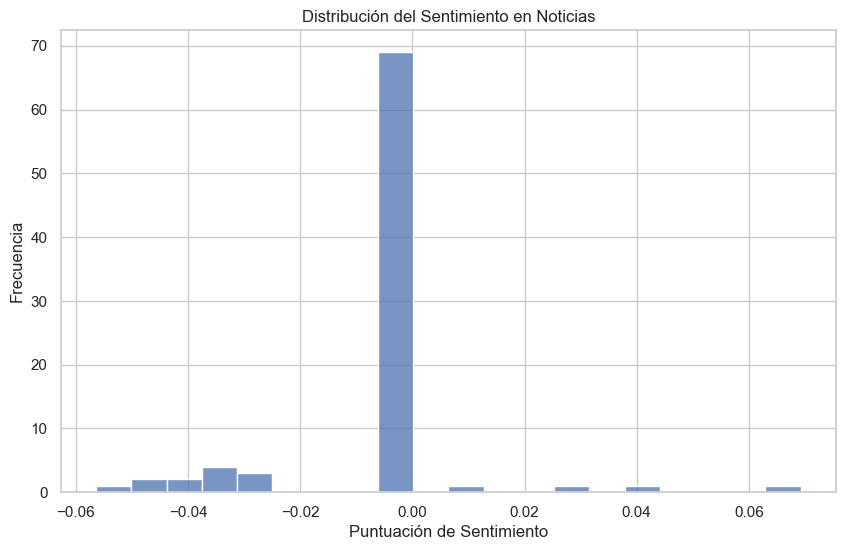

In [3]:
# Obtener noticias
news_data = collector.get_rss_news()

# Mostrar últimas noticias y su sentimiento
print("Últimas 5 noticias y su sentimiento:")
latest_news = news_data[['title', 'sentiment_score']].head()
display(latest_news)

# Visualizar distribución de sentimiento
plt.figure(figsize=(10, 6))
sns.histplot(data=news_data, x='sentiment_score', bins=20)
plt.title('Distribución del Sentimiento en Noticias')
plt.xlabel('Puntuación de Sentimiento')
plt.ylabel('Frecuencia')
plt.show()

### 2.3.1 Noticias de la FED

Últimas 5 noticias de la FED y su sentimiento:


,title,sentiment_score
date,,
2024-11-07 19:00:00,Federal Reserve issues FOMC statement,0.0
2024-10-15 18:00:00,Minutes of the Board's discount rate meetings ...,0.0
2024-10-09 18:00:00,"Minutes of the Federal Open Market Committee, ...",0.0
2024-09-18 18:00:00,Federal Reserve issues FOMC statement,0.0
2024-09-18 18:00:00,Federal Reserve Board and Federal Open Market ...,0.0


/Users/mayel/repos/banco-base-proyecto-test/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


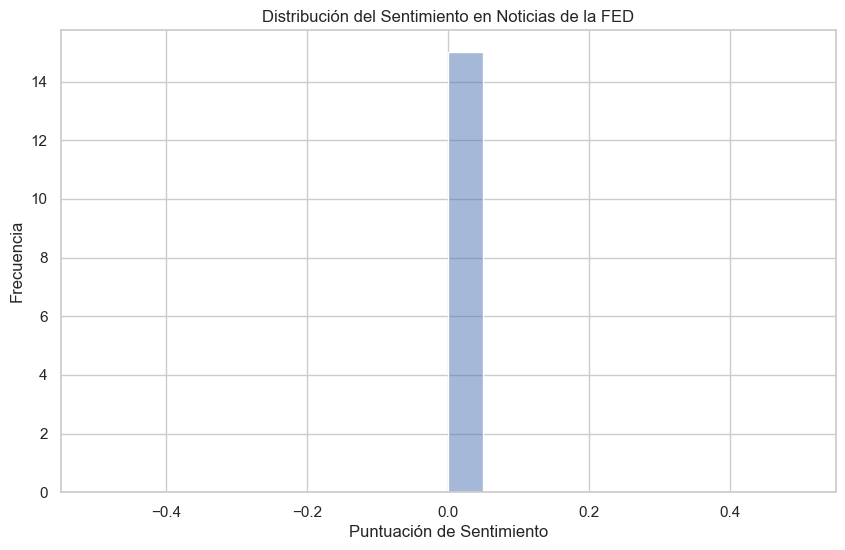


Estadísticas del Sentimiento en Noticias de la FED:
Sentimiento promedio: 0.000
Sentimiento máximo: 0.000
Sentimiento mínimo: 0.000


In [4]:
# Obtener noticias
news_data = collector.get_rss_news()

# Filtrar noticias de la FED
fed_news = news_data[news_data['source'] == 'fed_minutas']

# Verificar si se obtuvieron noticias de la FED
if not fed_news.empty:
    # Mostrar las últimas 5 noticias de la FED y su sentimiento
    print("Últimas 5 noticias de la FED y su sentimiento:")
    latest_fed_news = fed_news[['title', 'sentiment_score']].head()
    display(latest_fed_news)

    # Visualizar la distribución del sentimiento en noticias de la FED
    plt.figure(figsize=(10, 6))
    sns.histplot(data=fed_news, x='sentiment_score', bins=20, kde=True)
    plt.title('Distribución del Sentimiento en Noticias de la FED')
    plt.xlabel('Puntuación de Sentimiento')
    plt.ylabel('Frecuencia')
    plt.show()

    # Calcular y mostrar estadísticas de sentimiento para las noticias de la FED
    print("\nEstadísticas del Sentimiento en Noticias de la FED:")
    print(f"Sentimiento promedio: {fed_news['sentiment_score'].mean():.3f}")
    print(f"Sentimiento máximo: {fed_news['sentiment_score'].max():.3f}")
    print(f"Sentimiento mínimo: {fed_news['sentiment_score'].min():.3f}")
else:
    print("No se obtuvieron noticias de la FED.")


### 2.4 Ticker del bono del Tesoro a 10 años

In [6]:
us_treasury_ticker = '^TNX'

# Obtener datos del rendimiento del bono del Tesoro a 10 años
us_treasury_data = collector.get_yahoo_data([us_treasury_ticker], start_date_str, end_date_str)

# Verificar si se obtuvieron datos
if not us_treasury_data.empty:
    # Extraer el precio de cierre
    us_treasury_close = us_treasury_data[(us_treasury_ticker, 'Close')]

    # Ajustar el rendimiento a porcentaje (dividir entre 10)
    us_treasury_close_percent = us_treasury_close / 10  # Valor real en porcentaje

    # Visualizar el rendimiento
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=us_treasury_close_percent.index,
        y=us_treasury_close_percent,
        mode='lines',
        name='Rendimiento Bono del Tesoro EE.UU. 10 Años'
    ))

    fig.update_layout(
        title='Rendimiento del Bono del Tesoro EE.UU. a 10 Años',
        xaxis_title='Fecha',
        yaxis_title='Rendimiento (%)',
        template='plotly_white'
    )
    fig.show()
else:
    print("No se pudo obtener el rendimiento del bono del Tesoro de EE.UU.")


✓ Datos completos obtenidos para ^TNX


### 2.5 Obtener tasa de interés de Banxico

In [13]:
interest_rate_mx = collector.get_banxico_interest_rate(start_date_str, end_date_str)
print(start_date_str)
print(end_date_str)

# Verificar si se obtuvieron datos
if not interest_rate_mx.empty:
    # Visualizar la tasa de interés
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=interest_rate_mx.index,
        y=interest_rate_mx['tasa_interes_banxico'],
        mode='lines',
        name='Tasa de Interés Banxico'
    ))

    fig.update_layout(
        title='Tasa de Interés Objetivo del Banco de México',
        xaxis_title='Fecha',
        yaxis_title='Tasa (%)',
        template='plotly_white'
    )
    fig.show()
else:
    print("No se pudo obtener la tasa de interés de Banxico.")


2023-11-12
2024-11-11



Estadísticas de los Rendimientos del Tipo de Cambio USD/MXN:
count    126.000000
mean       0.001618
std        0.009721
min       -0.023999
25%       -0.004803
50%        0.001782
75%        0.007247
max        0.040720
Name: returns, dtype: float64
Últimas 5 noticias de la FED y su sentimiento:


,title,sentiment_score
date,,
2024-11-07 19:00:00,Federal Reserve issues FOMC statement,0.0
2024-10-15 18:00:00,Minutes of the Board's discount rate meetings ...,0.0
2024-10-09 18:00:00,"Minutes of the Federal Open Market Committee, ...",0.0
2024-09-18 18:00:00,Federal Reserve issues FOMC statement,0.0
2024-09-18 18:00:00,Federal Reserve Board and Federal Open Market ...,0.0


/Users/mayel/repos/banco-base-proyecto-test/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



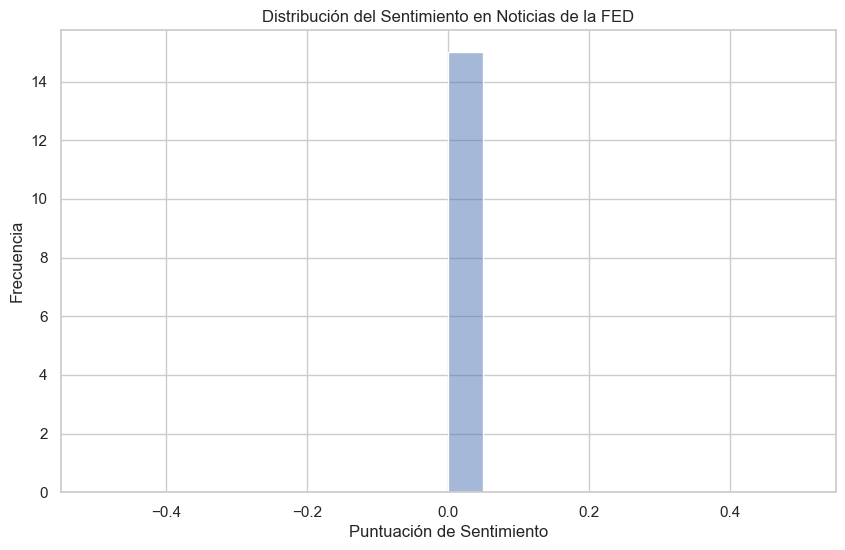


Estadísticas del Sentimiento en Noticias de la FED:
Sentimiento promedio: 0.000
Sentimiento máximo: 0.000
Sentimiento mínimo: 0.000


In [7]:
from datetime import datetime, timedelta
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# Definir el rango de fechas (último mes)
end_date = datetime.now()
start_date = end_date - timedelta(days=180)
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Obtener datos de tipo de cambio USD/MXN desde Banxico
fx_data = collector.get_banxico_data(start_date_str, end_date_str)

# Obtener noticias de la FED
news_data = collector.get_rss_news()
fed_news = news_data[news_data['source'] == 'fed_minutas']

# Verificar si se obtuvieron datos
if fx_data.empty:
    print("No se obtuvieron datos de tipo de cambio USD/MXN.")
else:
    # Calcular rendimientos logarítmicos del tipo de cambio USD/MXN
    fx_data['returns'] = np.log(fx_data['usdmxn_fix'] / fx_data['usdmxn_fix'].shift(1))

    # Visualizar el tipo de cambio USD/MXN con líneas en las fechas de noticias de la FED
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=fx_data.index,
        y=fx_data['usdmxn_fix'],
        mode='lines',
        name='USD/MXN Fix'
    ))

    # Añadir líneas verticales en las fechas de noticias de la FED
    if not fed_news.empty:
        for date in fed_news.index:
            fig.add_shape(
                type="line",
                x0=date, y0=fx_data['usdmxn_fix'].min(),
                x1=date, y1=fx_data['usdmxn_fix'].max(),
                line=dict(color="red", width=1, dash="dot"),
                name="Fecha de Minuta de la FED"
            )

    fig.update_layout(
        title='Tipo de Cambio USD/MXN y Fechas de Minutas de la FED',
        xaxis_title='Fecha',
        yaxis_title='Tipo de Cambio',
        template='plotly_white'
    )
    fig.show()

    # Visualizar rendimientos del tipo de cambio USD/MXN
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=fx_data.index,
        y=fx_data['returns'],
        mode='lines',
        name='Rendimientos USD/MXN'
    ))

    # Añadir líneas verticales en las fechas de noticias de la FED en el gráfico de rendimientos
    if not fed_news.empty:
        for date in fed_news.index:
            fig.add_shape(
                type="line",
                x0=date, y0=fx_data['returns'].min(),
                x1=date, y1=fx_data['returns'].max(),
                line=dict(color="red", width=1, dash="dot"),
                name="Fecha de Minuta de la FED"
            )

    fig.update_layout(
        title='Rendimientos Logarítmicos del Tipo de Cambio USD/MXN con Fechas de Minutas de la FED',
        xaxis_title='Fecha',
        yaxis_title='Rendimiento',
        template='plotly_white'
    )
    fig.show()

    # Mostrar estadísticas de los rendimientos del tipo de cambio USD/MXN
    print("\nEstadísticas de los Rendimientos del Tipo de Cambio USD/MXN:")
    print(fx_data['returns'].describe())

# Mostrar últimas 5 noticias de la FED y sus estadísticas de sentimiento
if not fed_news.empty:
    print("Últimas 5 noticias de la FED y su sentimiento:")
    latest_fed_news = fed_news[['title', 'sentiment_score']].head()
    display(latest_fed_news)

    # Visualizar la distribución del sentimiento en noticias de la FED
    plt.figure(figsize=(10, 6))
    sns.histplot(data=fed_news, x='sentiment_score', bins=20, kde=True)
    plt.title('Distribución del Sentimiento en Noticias de la FED')
    plt.xlabel('Puntuación de Sentimiento')
    plt.ylabel('Frecuencia')
    plt.show()

    # Calcular y mostrar estadísticas de sentimiento para las noticias de la FED
    print("\nEstadísticas del Sentimiento en Noticias de la FED:")
    print(f"Sentimiento promedio: {fed_news['sentiment_score'].mean():.3f}")
    print(f"Sentimiento máximo: {fed_news['sentiment_score'].max():.3f}")
    print(f"Sentimiento mínimo: {fed_news['sentiment_score'].min():.3f}")
else:
    print("No se obtuvieron noticias de la FED.")


## 3. Análisis Estadístico de los Datos

✓ Datos completos obtenidos para ^TNX
✓ Datos completos obtenidos para GFNORTEO.MX
✓ Datos completos obtenidos para VOLARA.MX
✓ Datos completos obtenidos para MXNUSD=X


/Users/mayel/repos/banco-base-proyecto-test/venv/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



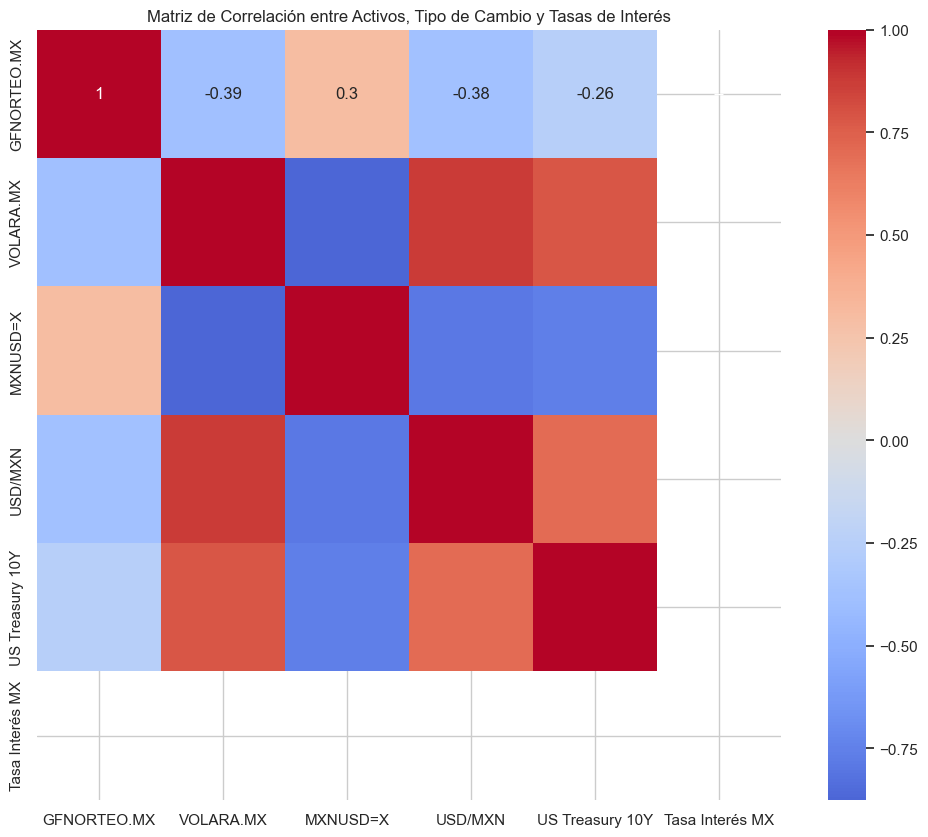


Estadísticas de Rendimientos del Tipo de Cambio USD/MXN:
count    249.000000
mean       0.000600
std        0.007996
min       -0.023999
25%       -0.004059
50%        0.000105
75%        0.004578
max        0.040720
Name: returns_usd_mxn, dtype: float64

Estadísticas de Precios de Cierre y Tasas de Interés:

Ticker: GFNORTEO.MX
count     22.000000
mean     144.051819
std        3.376418
min      137.979996
25%      141.739998
50%      144.195000
75%      146.032505
max      150.240005
Name: GFNORTEO.MX, dtype: float64

Ticker: VOLARA.MX
count    22.000000
mean     14.278636
std       0.881364
min      12.150000
25%      13.982500
50%      14.325000
75%      14.920000
max      15.390000
Name: VOLARA.MX, dtype: float64

Ticker: MXNUSD=X
count    22.000000
mean      0.050169
std       0.000623
min       0.049053
25%       0.049774
50%       0.050116
75%       0.050452
max       0.051815
Name: MXNUSD=X, dtype: float64

Ticker: USD/MXN
count    22.000000
mean     19.952891
std       0.261

In [15]:
# Lista de tickers relevantes (acciones y tipo de cambio USD/MXN)
mx_tickers = ['GFNORTEO.MX', 'VOLARA.MX', 'MXNUSD=X']
us_treasury_ticker = '^TNX'  # Ticker del bono del Tesoro de EE.UU. a 10 años

# Obtener datos de tipo de cambio USD/MXN desde Banxico
fx_data = collector.get_banxico_data(start_date_str, end_date_str)

# Obtener tasa de interés de Banxico
interest_rate_mx = collector.get_banxico_interest_rate(start_date_str, end_date_str)

# Obtener datos del rendimiento del bono del Tesoro de EE.UU. a 10 años
us_treasury_data = collector.get_yahoo_data([us_treasury_ticker], start_date_str, end_date_str)

# Verificar si se obtuvieron todos los datos necesarios
if fx_data.empty or interest_rate_mx.empty or us_treasury_data.empty:
    print("No se obtuvieron todos los datos requeridos.")
else:
    # Cálculo de rendimientos logarítmicos de USD/MXN para medir volatilidad
    fx_data['returns_usd_mxn'] = np.log(fx_data['usdmxn_fix'] / fx_data['usdmxn_fix'].shift(1))

    # Obtener datos de acciones y tipo de cambio desde Yahoo Finance
    stocks_data = collector.get_yahoo_data(mx_tickers, start_date_str, end_date_str)
    if stocks_data.empty:
        print("No se obtuvieron datos para los tickers proporcionados.")
    else:
        # Extraer precios de cierre de cada ticker de acciones y del tipo de cambio USD/MXN
        close_prices = pd.DataFrame({ticker: stocks_data[(ticker, 'Close')] for ticker in mx_tickers if (ticker, 'Close') in stocks_data.columns})
        close_prices['USD/MXN'] = fx_data['usdmxn_fix']

        # Extraer el rendimiento del bono del Tesoro de EE.UU. a 10 años y ajustarlo a porcentaje
        us_treasury_close = us_treasury_data[(us_treasury_ticker, 'Close')] / 10
        close_prices['US Treasury 10Y'] = us_treasury_close

        # Añadir la tasa de interés de Banxico
        close_prices['Tasa Interés MX'] = interest_rate_mx['tasa_interes_banxico']

        # Visualización de Retornos Normalizados (Tema: Análisis de datos financieros)
        fig = go.Figure()
        for ticker in close_prices.columns:
            normalized_price = close_prices[ticker] / close_prices[ticker].iloc[0]
            fig.add_trace(go.Scatter(x=close_prices.index, y=normalized_price, mode='lines', name=ticker))
        fig.update_layout(title='Retornos Normalizados de Activos, Tipo de Cambio y Tasas de Interés', xaxis_title='Fecha', yaxis_title='Retorno Normalizado', template='plotly_white')
        fig.show()

        # Calcular y visualizar matriz de correlación (Tema: Estadística y probabilidad)
        corr_matrix = close_prices.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Matriz de Correlación entre Activos, Tipo de Cambio y Tasas de Interés')
        plt.show()

        # Análisis de Rendimientos y Volatilidad del Tipo de Cambio USD/MXN
        print("\nEstadísticas de Rendimientos del Tipo de Cambio USD/MXN:")
        print(fx_data['returns_usd_mxn'].describe())

        # Análisis de estadísticas de los precios de cierre de los activos, tipo de cambio y tasas de interés
        print("\nEstadísticas de Precios de Cierre y Tasas de Interés:")
        for ticker in close_prices.columns:
            print(f"\nTicker: {ticker}")
            print(close_prices[ticker].describe())




## 4. Almacenamiento de Datos

In [16]:
# Crear directorio si no existe
output_dir = 'data/processed'
os.makedirs(output_dir, exist_ok=True)

# Crear diccionario con todos los datos relevantes
market_data = {
    'fx_rates': fx_data,                      # Tipo de cambio USD/MXN y rendimientos
    'stocks': stocks_data,                    # Datos de las acciones obtenidos de Yahoo Finance
    'news': news_data,                        # Noticias de fuentes relevantes
    'correlation_matrix': pd.DataFrame(corr_matrix) if not isinstance(corr_matrix, pd.DataFrame) else corr_matrix  # Convertir matriz a DataFrame si es necesario
}

# Guardar los datos procesados en formato CSV
for name, data in market_data.items():
    if isinstance(data, pd.DataFrame):  # Verificar que es un DataFrame antes de guardar
        data.to_csv(f'{output_dir}/{name}_{end_date_str}.csv', index=True)
    else:
        print(f"{name} no es un DataFrame y no se guardará como CSV.")

print(f"Datos guardados exitosamente en el directorio '{output_dir}'")

Datos guardados exitosamente en el directorio 'data/processed'


## 5. Resumen y Conclusiones

Este notebook ha realizado:
1. Recolección exitosa de datos de múltiples fuentes
2. Procesamiento y validación de datos
3. Análisis exploratorio inicial
4. Visualizaciones importantes del mercado
5. Almacenamiento de datos procesados

### Próximos Pasos
- Realizar análisis exploratorio más detallado
- Implementar feature engineering
- Desarrollar modelos predictivos
- Crear estrategias de trading